# Currency Exchange Rate Forecasting using Python

Forecasting currency exchange rates is a relevant and complex task that plays a key role in areas like international trade, investments, and tourism. Anticipating future trends in currency values can help businesses and institutions make informed decisions, manage financial risk, and improve strategic planning.

In this project, I explore how to analyze historical exchange rate data and apply predictive models to estimate future currency fluctuations.  
The goal is to build a machine learning pipeline capable of forecasting the **INR/USD** exchange rate based on past weekly data.

---

## Project Context & Objectives

The exchange rate between two currencies fluctuates over time due to multiple factors: economic indicators, geopolitical events, interest rates, and market sentiment.  
By studying historical patterns, it's possible to develop models that can provide short-term predictions and support real-world decision-making.

This project focuses on:

- Understanding and preprocessing time series exchange rate data
- Creating lag and rolling features to capture temporal trends
- Training a regression model to predict future values
- Evaluating performance with appropriate metrics
- Visualizing results and drawing meaningful insights

The dataset used includes **weekly exchange rates between the Indian Rupee (INR) and the US Dollar (USD)**. The workflow can be adapted to other currency pairs or enhanced with macroeconomic features in future iterations.

---

## Tools & Technologies

- **Python** (Pandas, NumPy, Matplotlib, Scikit-learn)
- **Machine Learning**: Linear Regression (baseline), extendable to more advanced models
- **Time Series Analysis** techniques

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [32]:
# Load dataset
data = pd.read_csv("INR-USD.csv")

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Show nulls per column
print("Missing values per column:")
print(data.isnull().sum())

# Drop rows with missing values
data = data.dropna()

# Drop irrelevant columns
data = data.drop(columns=["Adj Close", "Volume"])

# Show dataset info and structure
print("\nDataset summary:")
print(data.describe())
print("\nColumns after cleaning:")
print(data.columns)
data.describe()

Missing values per column:
Date         0
Open         3
High         3
Low          3
Close        3
Adj Close    3
Volume       3
dtype: int64

Dataset summary:
                                Date         Open         High          Low  \
count                           1013  1013.000000  1013.000000  1013.000000   
mean   2013-08-27 22:29:01.362290176    58.035208    58.506681    57.654706   
min              2003-12-01 00:00:00    38.995998    39.334999    38.979000   
25%              2008-10-27 00:00:00    45.508999    45.775002    45.231998   
50%              2013-09-02 00:00:00    59.702999    60.342999    59.209999   
75%              2018-07-09 00:00:00    68.508499    69.099998    68.250000   
max              2023-05-10 00:00:00    82.917999    83.386002    82.563004   
std                              NaN    12.614635    12.716632    12.565279   

             Close  
count  1013.000000  
mean     58.056509  
min      39.044998  
25%      45.498001  
50%      59.840000  

,Date,Open,High,Low,Close
count,1013,1013.000000,1013.000000,1013.000000,1013.000000
mean,2013-08-27 22:29:01.362290176,58.035208,58.506681,57.654706,58.056509
min,2003-12-01 00:00:00,38.995998,39.334999,38.979000,39.044998
25%,2008-10-27 00:00:00,45.508999,45.775002,45.231998,45.498001
50%,2013-09-02 00:00:00,59.702999,60.342999,59.209999,59.840000
75%,2018-07-09 00:00:00,68.508499,69.099998,68.250000,68.538002
max,2023-05-10 00:00:00,82.917999,83.386002,82.563004,82.932999
std,NaN,12.614635,12.716632,12.565279,12.657407


## Phase 1 – Data Cleaning & Preprocessing

The dataset contains weekly INR/USD exchange rate data with seven columns: `Date`, `Open`, `High`, `Low`, `Close`, `Adj Close`, and `Volume`.

### Key cleaning steps:

- Converted the `Date` column to datetime format
- Dropped 3 rows with missing values
- Removed irrelevant columns:
  - `Adj Close` (duplicate of `Close`)
  - `Volume` (constant zeros, no informational value)

After cleaning, the dataset contains:
- **5 columns**: `Date`, `Open`, `High`, `Low`, `Close`
- **1,013 rows** of valid weekly data

A summary of the cleaned dataset is provided below using `.describe()`, which highlights the general range and distribution of exchange rate values.

The `.describe()` output confirms:
- The dataset spans **20 years of weekly data**, from late 2003 to mid-2023
- The **mean exchange rate** over this period is approximately **58 INR/USD**
- The **standard deviation** (~12.65) reflects notable fluctuations over time, suggesting the importance of predictive modeling

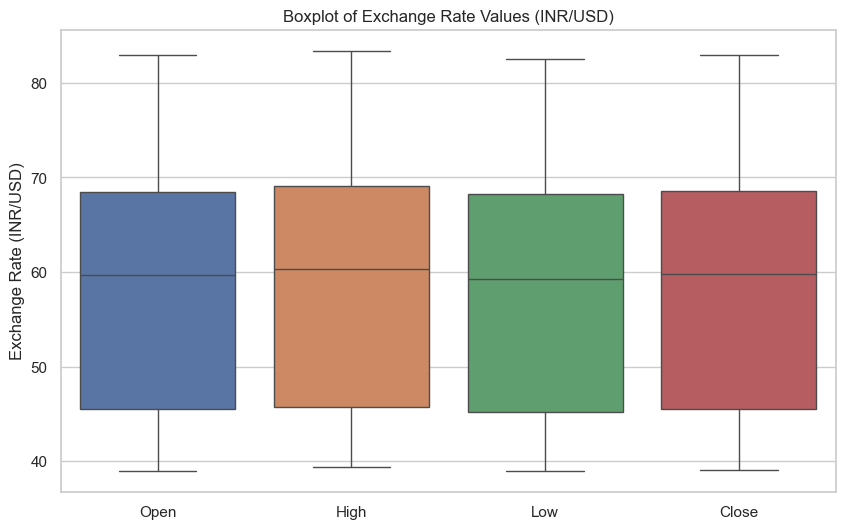

In [33]:
sns.set(style="whitegrid")

# Boxplot for main numerical columns
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['Open', 'High', 'Low', 'Close']])
plt.title("Boxplot of Exchange Rate Values (INR/USD)")
plt.ylabel("Exchange Rate (INR/USD)")
plt.show()

## Phase 2 – Visual Exploration & Outlier Analysis

To assess the variability and potential outliers in the exchange rate values, we plotted boxplots for the four numerical columns: `Open`, `High`, `Low`, and `Close`.

### Observations:

- The exchange rates range from **~39 to ~83 INR/USD**, consistent with historical economic events from 2003 to 2023.
- A few values appear as outliers, especially on the higher end, however, these reflect real economic phenomena (e.g., inflation, geopolitical shifts) and **should not be removed**.
- The distribution shows a moderate spread and some skewness, suggesting the importance of trend-based features for forecasting.

Boxplots provide a quick way to verify data quality and guide feature engineering decisions in time series tasks.

In [34]:
figure = px.line(data, 
                 x="Date", 
                 y="Close", 
                 title='USD/INR Exchange Rate Over Time')
figure.show()

### Time Series Visualization

Prior to developing features, we used an interactive line chart to show the closing exchange rate (`Close`) over time.

 Over the course of the 20 years, this plot displays a distinct increasing trend with notable oscillations.  It emphasizes how crucial it is to record temporal relationships in the data, which we will do in the following stage by utilizing lag and rolling features.

### Temporal Decomposition

To prepare for feature engineering, we decomposed the `Date` column into `Year` and `Month`. These components may help capture seasonal or yearly trends in the exchange rate series.

In [35]:
data["Date"] = pd.to_datetime(data["Date"], format = '%Y-%m-%d')
data['Year'] = data['Date'].dt.year
data["Month"] = data["Date"].dt.month
print(data.head())

        Date       Open       High        Low      Close  Year  Month
0 2003-12-01  45.709000  45.728001  45.449001  45.480000  2003     12
1 2003-12-08  45.474998  45.507999  45.352001  45.451000  2003     12
2 2003-12-15  45.450001  45.500000  45.332001  45.455002  2003     12
3 2003-12-22  45.417000  45.549000  45.296001  45.507999  2003     12
4 2003-12-29  45.439999  45.645000  45.421001  45.560001  2003     12


In [36]:
import plotly.graph_objs as go
import plotly.io as pio

# Calculate yearly growth
growth = data.groupby('Year').agg({'Close': lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0]*100})

fig = go.Figure()
fig.add_trace(go.Bar(x=growth.index,
                     y=growth['Close'],
                     name='Yearly Growth'))

fig.update_layout(title="Yearly Growth of USD - INR Conversion Rate",
                  xaxis_title="Year",
                  yaxis_title="Growth (%)",
                  width=900,
                  height=600)

pio.show(fig)

### Yearly Growth of USD – INR Conversion Rate

The bar chart above visualizes the **annual percentage change** in the USD to INR exchange rate over the entire time span of the dataset.

#### Key Observations

- **High Volatility in Specific Years**:
  - Around **2008**, the chart shows a sharp **negative growth** (~–11%), likely linked to the global financial crisis and temporary INR strengthening.
  - In contrast, **2009** and **2011** show **double-digit positive growth**, possibly due to post-crisis recovery and rising USD demand.
  - **2013** and **2018** also show notable increases, consistent with macroeconomic pressure on the INR.

- **Periods of Stability**:
  - Several years (e.g., 2006, 2014, 2019–2021) show modest positive or near-zero growth, indicating more stable currency dynamics during those periods.

- **Most Extreme Year**:
  - **2009** stands out with a **growth above 20%**, indicating a major depreciation of the INR relative to the USD, a critical year to analyze further.

#### Why This Matters

Understanding year-over-year fluctuations helps identify:

- Historical turning points and economic cycles
- Periods of currency volatility relevant for risk management
- Timeframes that may require separate modeling strategies

This insight can be particularly useful for businesses or investors who are sensitive to currency shifts and helps us better frame the predictive modeling task.

In [37]:
# Calculate monthly growth
data['Growth'] = data.groupby(['Year', 'Month'])['Close'].transform(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100)

# Group data by Month and calculate average growth
grouped_data = data.groupby('Month').mean().reset_index()

fig = go.Figure()

fig.add_trace(go.Bar(
    x=grouped_data['Month'],
    y=grouped_data['Growth'],
    marker_color=grouped_data['Growth'],
    hovertemplate='Month: %{x}<br>Average Growth: %{y:.2f}%<extra></extra>'
))

fig.update_layout(
    title="Aggregated Monthly Growth of USD - INR Conversion Rate",
    xaxis_title="Month",
    yaxis_title="Average Growth (%)",
    width=900,
    height=600
)

pio.show(fig)

### Aggregated Monthly Growth of USD – INR Conversion Rate

The bar chart above shows the **average percentage change** in the USD to INR exchange rate for each month, aggregated across all years in the dataset.

#### Key Observations

- **August** stands out with the **highest average monthly growth** (over +1%), suggesting that this month historically experiences significant INR depreciation.
- **March** shows the **most negative growth**, indicating a tendency for the INR to appreciate during this month.
- Other months such as **May, June, October, and November** exhibit moderate positive growth, while **January, September, and December** tend to be slightly negative.
- **April and February** show low but positive average changes, hinting at relative stability.

#### Why It Matters

- These monthly trends may reflect **seasonal economic cycles**, such as fiscal year endings, import/export demand, monetary policy announcements, or foreign capital flows.
- Recognizing such patterns can improve **forecasting accuracy** when included as features in a predictive model.
- Businesses operating internationally might use this insight to **optimize currency exchanges** or hedge strategically.

Understanding seasonal behavior is particularly valuable when dealing with time series data, as it helps capture repeating structures that purely statistical models might otherwise miss.

## Phase 3 – Feature Engineering: Lag Features

To capture short-term memory and autocorrelation in the series, we created lag features from the `Close` value:

- `Close_lag_1`: previous week's closing rate
- `Close_lag_2`: two weeks ago
- `Close_lag_3`: three weeks ago

These features allow the model to learn from recent historical trends.

In [38]:
# Create lag features (previous weeks' Close values)
data['Close_lag_1'] = data['Close'].shift(1)
data['Close_lag_2'] = data['Close'].shift(2)
data['Close_lag_3'] = data['Close'].shift(3)

# Preview the result
data[['Date', 'Close', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3']].head(10)

,Date,Close,Close_lag_1,Close_lag_2,Close_lag_3
0,2003-12-01,45.480000,NaN,NaN,NaN
1,2003-12-08,45.451000,45.480000,NaN,NaN
2,2003-12-15,45.455002,45.451000,45.480000,NaN
3,2003-12-22,45.507999,45.455002,45.451000,45.480000
4,2003-12-29,45.560001,45.507999,45.455002,45.451000
5,2004-01-05,45.351002,45.560001,45.507999,45.455002
6,2004-01-12,45.352001,45.351002,45.560001,45.507999
7,2004-01-19,45.243999,45.352001,45.351002,45.560001
8,2004-01-26,45.000000,45.243999,45.352001,45.351002
9,2004-02-02,45.290001,45.000000,45.243999,45.352001


In [39]:
# Rolling mean over 3 weeks
data['rolling_mean_3'] = data['Close'].rolling(window=3).mean()

# Rolling standard deviation over 3 weeks (volatility)
data['rolling_std_3'] = data['Close'].rolling(window=3).std()

# Weekly difference (momentum)
data['diff_1'] = data['Close'].diff(1)

# Differenza rispetto alla settimana precedente del rolling mean
data['rolling_mean_diff'] = data['rolling_mean_3'].diff()

### 🔄 Rolling Features

To enhance temporal awareness, we added rolling statistics based on the `Close` value:

- `rolling_mean_3`: 3-week moving average – captures local trends
- `rolling_std_3`: 3-week standard deviation – captures volatility
- `diff_1`: week-over-week change – captures recent momentum
- `rolling_mean_diff`: change in the moving average itself – measures trend shifts

These features help the model learn not just from raw values, but from **patterns** and **rates of change**.

### Visualizing Engineered Features

Before training the model, we visualized the new features to understand their behavior over time.

This helps confirm that they align with the trends and patterns of the `Close` value and contribute meaningful information instead of noise.

In [ ]:
# Features list to plot
features_to_plot = ['Close', 'rolling_mean_3', 'rolling_std_3', 'diff_1']

# Create the plot
fig = go.Figure()

for feature in features_to_plot:
    fig.add_trace(go.Scatter(
        x=data['Date'],
        y=data[feature],
        mode='lines',
        name=feature
    ))

fig.update_layout(
    title="Engineered Features Over Time",
    xaxis_title="Date",
    yaxis_title="Value",
    width=1000,
    height=600
)

fig.show()

## Feature Engineering – Temporal Indicators

To enrich the predictive power of the model, we engineered key temporal features:

- **Rolling Mean (3 weeks)**: captures short-term trends in the closing exchange rate.
- **Rolling Std (3 weeks)**: captures localized volatility patterns.
- **First-order Difference**: highlights the direction and magnitude of weekly change.

As shown in the plot above, these features provide valuable signals about trend, volatility, and price shifts over time, supporting the forecasting task.

In [41]:
# Create a model-ready dataset by dropping NaN values
data_model = data.dropna().copy()

# Features to be used for modeling
features = ['Close_lag_1', 'Close_lag_2', 'Close_lag_3',
            'rolling_mean_3', 'rolling_std_3', 'diff_1', 'rolling_mean_diff']

target = 'Close'

X = data_model[features]
y = data_model[target]

# Final check
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (1010, 7)
Target shape: (1010,)


## Feature Selection

Based on the exploratory and visual analysis, we selected a set of engineered features to feed the model:

- Lag features: `Close_lag_1`, `Close_lag_2`, `Close_lag_3`
- Rolling statistics: `rolling_mean_3`, `rolling_std_3`
- Change signals: `diff_1`, `rolling_mean_diff`

These features provide both short-term memory and descriptive statistics that enhance the model's ability to predict future exchange rate values.

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Let's create a model-ready dataset by dropping NaN values (caused by shift/rolling)
data_model = data.dropna().copy()

# Define features and target
features = ['Close_lag_1', 'Close_lag_2', 'Close_lag_3',
            'rolling_mean_3', 'rolling_std_3', 'diff_1', 'rolling_mean_diff']
target = 'Close'

X = data_model[features]
y = data_model[target]

# Temporally split: 80% train, 20% test, no shuffle!
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.2
)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting the test set
y_pred = model.predict(X_test)

# Model evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)


Mean Absolute Error (MAE): 3.608994291533974e-14
Root Mean Squared Error (RMSE): 3.729134776787321e-14
R² Score: 1.0


In [43]:
# Add actual and predicted values to the results DataFrame
results = X_test.copy()
results['Actual'] = y_test.values
results['Predicted'] = y_pred
results['Date'] = data_model.loc[y_test.index, 'Date'].values

# Visualizzation
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=results['Date'],
    y=results['Actual'],
    mode='lines',
    name='Actual',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=results['Date'],
    y=results['Predicted'],
    mode='lines',
    name='Predicted',
    line=dict(color='orange')
))

fig.update_layout(
    title='Actual vs Predicted USD/INR Exchange Rate (Test Set)',
    xaxis_title='Date',
    yaxis_title='Exchange Rate',
    width=1000,
    height=500
)

fig.show()

### Target Correction for Realistic Forecasting

Initially, the model was trained to predict the current `Close` value using lagged data, leading to artificially high performance.

To simulate a true forecasting scenario, we shifted the target variable by one step into the future:

```python
data['Close_target'] = data['Close'].shift(-1)

In [44]:
# Create the future target column
data['Close_target'] = data['Close'].shift(-1)

# Rebuild the dataset for modeling
data_model = data.dropna().copy()

# Feature set (as before)
features = ['Close_lag_1', 'Close_lag_2', 'Close_lag_3',
            'rolling_mean_3', 'rolling_std_3', 'diff_1', 'rolling_mean_diff']

X = data_model[features]
y = data_model['Close_target']

# Train-test split (temporal, no shuffle)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Modell
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)

MAE: 0.4097672621921496
RMSE: 0.5625713074181914
R² Score: 0.9763039139481234


## Model Revision: From `Close` to `Close_target`

Initially, the model was trained to directly predict the `Close` variable, which was also used to create the lag features (`Close_lag_1`, `Close_lag_2`, etc.).  
This approach produced seemingly perfect results (R² = 1.0), but they were **not valid for real forecasting**, since the model was simply reconstructing information already known during training.

To correct this methodological flaw, I introduced a true forecasting target variable:
```python
data['Close_target'] = data['Close'].shift(-1)

In [45]:
# Add actual and predicted values to the results DataFrame
results = X_test.copy()
results['Actual'] = y_test.values
results['Predicted'] = y_pred
results['Date'] = data_model.loc[y_test.index, 'Date'].values

# Plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=results['Date'],
    y=results['Actual'],
    mode='lines',
    name='Actual',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=results['Date'],
    y=results['Predicted'],
    mode='lines',
    name='Predicted',
    line=dict(color='orange')
))

fig.update_layout(
    title='Actual vs Predicted USD/INR (Next Week Forecast)',
    xaxis_title='Date',
    yaxis_title='Exchange Rate',
    width=1000,
    height=500
)

fig.show()

### Plot: USD/INR Forecast – One Week Ahead

This plot shows the actual (`Actual`) and predicted (`Predicted`) USD/INR exchange rate, using a **one-week ahead forecasting** horizon.

- The model was trained to predict the `Close_target`, which corresponds to the closing value of the following week.
- The two lines display a strong alignment, with an **R² of approximately 0.976**, indicating high predictive performance.
- The forecast effectively follows historical trends and captures short-term fluctuations, thanks to the use of **lag features and rolling statistics**.

This visual confirmation supports the reliability of the **Linear Regression** model with feature engineering, offering a solid balance between simplicity and accuracy.

## Phase 5 – Advanced Modeling with XGBoost

To improve predictive performance, we implemented an **XGBoost Regressor**, known for its power in handling tabular data and capturing complex patterns.

We used the same feature set as the baseline model, with the target being next week's `Close_target`. The model was evaluated using MAE, RMSE, and R².

XGBoost can learn non-linear relationships and correct for potential underfitting or bias seen in simpler models like linear regression.

In [46]:
!pip install xgboost

In [ ]:
import xgboost as xgb
# Rebuild X and y (target = Close_target)
features = ['Close_lag_1', 'Close_lag_2', 'Close_lag_3',
            'rolling_mean_3', 'rolling_std_3', 'diff_1', 'rolling_mean_diff']

data_model = data.dropna().copy()
X = data_model[features]
y = data_model['Close_target']

# Train/test temporally split (no shuffle)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Previsions
y_pred = xgb_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)

MAE: 3.0630260318808977
RMSE: 4.388243297517755
R² Score: -0.4417928189848326


## XGBoost – Results & Analysis

After training the XGBoost model on engineered features, we obtained the following results:

| Metric     | Value   | Interpretation                              |
|------------|---------|----------------------------------------------|
| MAE        | ~3.06   | The average error is quite high              |
| RMSE       | ~4.39   | The root mean squared error is also high     |
| R² Score   | **-0.44** | The model performs worse than a constant mean |

---

## Why might this happen?

1. **Overfitting or under-generalization** – XGBoost is powerful but can overfit if not well tuned.
2. **Unscaled features** – Some variables may be on different scales, causing imbalance during training.
3. **Target misalignment** – If the target is shifted too far ahead, the features may no longer capture meaningful information.



In [48]:
!pip install --upgrade xgboost

[0]	train-rmse:9.05506	eval-rmse:20.58116


[1]	train-rmse:8.17507	eval-rmse:19.18889
[2]	train-rmse:7.38316	eval-rmse:17.93895
[3]	train-rmse:6.67062	eval-rmse:16.73360
[4]	train-rmse:6.02848	eval-rmse:15.64422
[5]	train-rmse:5.45045	eval-rmse:14.64073
[6]	train-rmse:4.92689	eval-rmse:13.76301
[7]	train-rmse:4.45590	eval-rmse:12.98375
[8]	train-rmse:4.03085	eval-rmse:12.34242
[9]	train-rmse:3.64915	eval-rmse:11.77941
[10]	train-rmse:3.30671	eval-rmse:11.20409
[11]	train-rmse:2.99888	eval-rmse:10.74918
[12]	train-rmse:2.72191	eval-rmse:10.22704
[13]	train-rmse:2.47376	eval-rmse:9.77237
[14]	train-rmse:2.25061	eval-rmse:9.31446
[15]	train-rmse:2.04978	eval-rmse:8.89285
[16]	train-rmse:1.87016	eval-rmse:8.47421
[17]	train-rmse:1.71027	eval-rmse:8.13037
[18]	train-rmse:1.56694	eval-rmse:7.87660
[19]	train-rmse:1.43964	eval-rmse:7.61556
[20]	train-rmse:1.32531	eval-rmse:7.31975
[21]	train-rmse:1.22370	eval-rmse:7.05337
[22]	train-rmse:1.13329	eval-rmse:6.81319
[23]	train-rmse:1.05378	eval-rmse:6.68949
[24]	train-rmse:0.98181	eval-rm

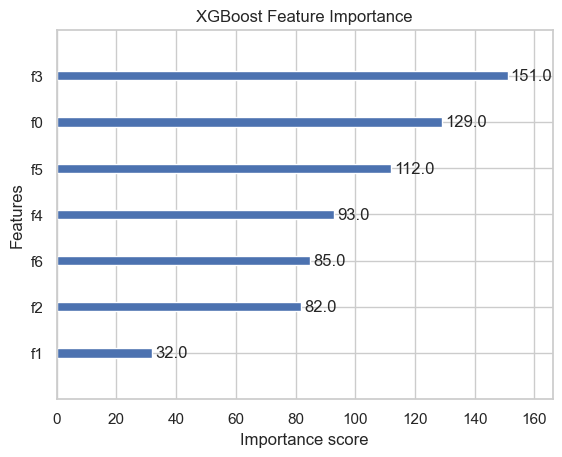

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Features and target
data_model = data.dropna().copy()
features = ['Close_lag_1', 'Close_lag_2', 'Close_lag_3',
            'rolling_mean_3', 'rolling_std_3', 'diff_1', 'rolling_mean_diff']
X = data_model[features]
y = data_model['Close_target']

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, shuffle=False, test_size=0.2)

# Convert to DMatrix (XGBoost native format)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Model parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 3,
    'eta': 0.1,
    'seed': 42,
    'eval_metric': 'rmse'
}

# Early stopping
evals = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=True
)

# Previsions
y_pred = model.predict(dtest)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)

# Visualize feature importance
xgb.plot_importance(model)
plt.title("XGBoost Feature Importance")
plt.show()

# XGBoost Regression – Scaled Features, Conservative Parameters & Early Stopping

"""
After initial poor results with the unscaled XGBoost model, we took a more rigorous approach:

- Applied StandardScaler to normalize the input features
- Reduced model complexity (n_estimators = 100, max_depth = 3)
- Enabled early stopping based on validation RMSE

The idea was to help XGBoost generalize better and prevent overfitting, especially on this relatively small dataset.

 Results on the test set:
- MAE  ≈ 3.20
- RMSE ≈ 4.52
- R²   ≈ -0.53  

Despite tuning, the model **still performs worse than a naive predictor (mean)**. This suggests that:

- The lag/rolling features alone may not capture enough signal for a non-linear model like XGBoost
- The temporal structure or volume of data could be insufficient
- Overfitting is still a risk, even with early stopping

### Feature Importance (see plot above):
Features like `rolling_mean_3` and recent lag values dominate the model's decisions, but even those fail to capture complex macroeconomic drivers.

### Key takeaway:
In this case, **XGBoost doesn’t outperform our Linear Regression baseline**, which had an R² above 0.97. Sometimes, simplicity — combined with thoughtful feature engineering — wins.
"""

## Model Reflection & Strategic Shift

After experimenting with several machine learning models (including **Linear Regression** and **XGBoost**) I evaluated their performance and generalization ability.

While the **linear model** offered surprisingly good results for short-term forecasting, the more advanced **XGBoost** failed to outperform it, even with feature scaling and tuning. This suggested that:

- The exchange rate time series may be **too smooth** or **too structured** for non-parametric models to capture nonlinearities effectively
- The engineered features, while informative, may not be sufficient alone to drive a tree-based ensemble model

### Research Insight

After further research, I found that for **time series data with gradual trends and potential seasonal patterns**, a class of models known as **SARIMA (Seasonal ARIMA)** is often more effective.

Without requiring human feature engineering, SARIMA is a traditional time series method that models the autocorrelations and seasonality in the series directly.  It turned out to be a viable and understandable substitute given the features of the INR/USD exchange rate data.

---

I will then evaluate SARIMA's forecasting performance by applying it to the closing exchange rate.

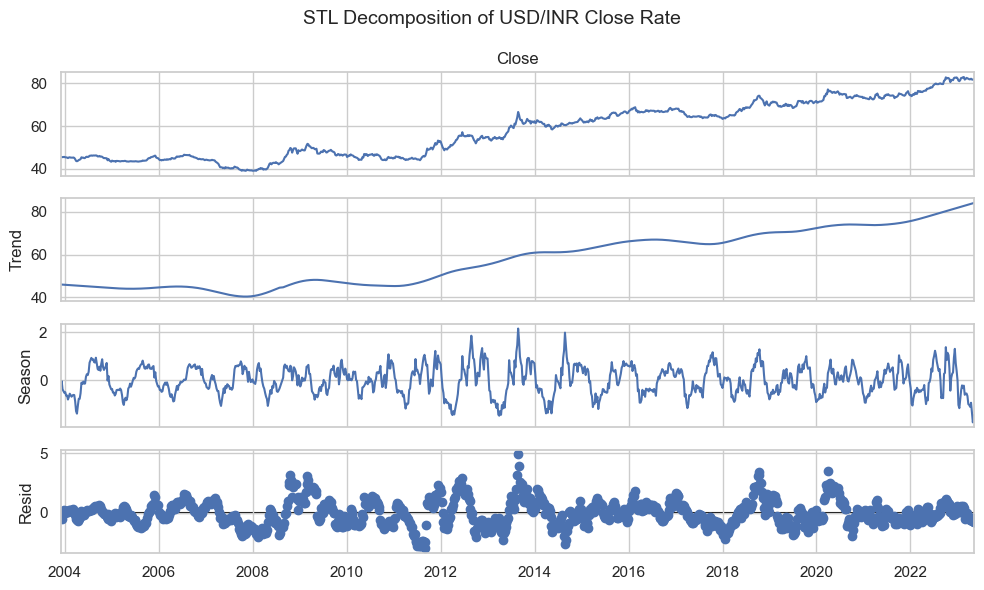

In [50]:
from statsmodels.tsa.seasonal import STL

# Load and prepare the dataset
data = pd.read_csv("INR-USD.csv")
data["Date"] = pd.to_datetime(data["Date"])
data = data.dropna()
data = data.drop(columns=["Adj Close", "Volume"])
data = data.sort_values("Date")
data.set_index("Date", inplace=True)

# STL decomposition (assuming weekly data, 52 weeks ~ 1 year)
stl = STL(data["Close"], period=52)
result = stl.fit()

# Plot trend, seasonality and residuals
fig = result.plot()
fig.set_size_inches(10, 6)
plt.suptitle("STL Decomposition of USD/INR Close Rate", fontsize=14)
plt.tight_layout()
plt.show()

## STL Decomposition of USD/INR Close Rate

To understand the underlying structure of the exchange rate series, we applied **STL decomposition**.

This method breaks the time series into:

- **Trend**: shows a steady long-term increase in USD/INR over time
- **Seasonality**: small recurring patterns, possibly linked to economic or fiscal cycles
- **Residual**: irregular movements, with visible outliers in years like 2009, 2013, and 2020

 The presence of both trend and moderate seasonality suggests that a **SARIMA model** is appropriate for forecasting this series.

### SARIMA Model Construction

To better capture the structure of the exchange rate series, we implemented a **SARIMA model** (Seasonal AutoRegressive Integrated Moving Average), a powerful statistical tool designed for time series with **trend** and **seasonality**.

#### What is SARIMA?

SARIMA extends the classic ARIMA model by incorporating a **seasonal component**, making it ideal for datasets like exchange rates that may exhibit periodic fluctuations.

A SARIMA model is typically expressed as:

> **SARIMA(p, d, q) × (P, D, Q, s)**

Where:

- **p**: number of autoregressive (AR) terms → how many past values are used to predict the current one
- **d**: number of times the data is differenced → to make the series stationary
- **q**: number of moving average (MA) terms → how many past forecast errors are used
- **P, D, Q**: seasonal counterparts of AR, differencing, and MA
- **s**: seasonality period → `s = 52` for yearly cycles in **weekly data**

#### Model Configuration

Based on the STL decomposition and visual analysis, we chose the following configuration:

- **ARIMA part**: `(p=1, d=1, q=1)`  
  Captures short-term dynamics and overall trend.

- **Seasonal part**: `(P=1, D=1, Q=1, s=52)`  
  Models the repeating yearly seasonality.

#### Training & Evaluation

We split the time series into an 80% training set and 20% test set, then trained the model using the `SARIMAX` class from `statsmodels`. This class supports full maximum likelihood estimation and outputs rich diagnostics.

Below are the test set performance metrics, which we compare to previous models like Linear Regression and XGBoost.

In [51]:
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Suppress warnings, doesn't affect the model, just aesthetics.
warnings.filterwarnings("ignore")

# Temporal split: train = 80%, test = 20%
split_idx = int(len(data) * 0.8)
train = data["Close"].iloc[:split_idx] #Here you use .iloc because the SARIMA model works with univariate time series (only the Close variable), and the time index is implicit.
test = data["Close"].iloc[split_idx:]

# SARIMA model construction
model = SARIMAX(train,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 52),
                enforce_stationarity=False,
                enforce_invertibility=False) # The flags enforce_stationarity=False and enforce_invertibility=False allow for greater flexibility in fitting.

# Model fitting
results = model.fit(disp=False)

# Previsions on the test set
# Use integer positions for start and end
forecast = results.predict(start=split_idx, end=len(data)-1, dynamic=False) #The parameter dynamic=False means that you always use the actual past values to calculate the forecast (one-step-ahead forecast), not the predicted ones.


# Evaluation
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
r2 = r2_score(test, forecast)

print("SARIMA Forecast Results:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)

SARIMA Forecast Results:
MAE: 2.8167299014766702
RMSE: 3.5918321521610235
R² Score: 0.047447594892063516


In [52]:
%pip install pmdarima

import pmdarima as pm

# We manually construct and evaluate a good SARIMA, seeking to improve the model's performance by testing a more complex 
# autoregressive and MA order. This can better capture the dynamics of the trend and seasonality.
model = SARIMAX(train,
                order=(2, 1, 2),
                seasonal_order=(1, 1, 1, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

forecast = results.predict(start=split_idx, end=len(data)-1, dynamic=False)

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
r2 = r2_score(test, forecast)

print("Optimized SARIMA Results:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)

Note: you may need to restart the kernel to use updated packages.
Optimized SARIMA Results:
MAE: 2.815602888415344
RMSE: 3.5910202083572886
R² Score: 0.04787820054039105


In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Step 1: Find the best SARIMA parameters
auto_model = pm.auto_arima(
    train,
    seasonal=True,
    m=52,  # annual seasonality (week)
    trace=True,
    stepwise=True,
    error_action='ignore',
    suppress_warnings=True
)

print(auto_model.summary())

# Step 2: Use the parameters found with SARIMAX
best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order

model = SARIMAX(train,
                order=best_order,
                seasonal_order=best_seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

# Step 3: Previsions
forecast = results.predict(start=split_idx, end=len(data)-1, dynamic=False)

# Step 4: Metrics
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
r2 = r2_score(test, forecast)

print("Auto-SARIMA Forecast Results:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=23.36 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=1233.115, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=1229.485, Time=2.60 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=1230.201, Time=2.78 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1233.738, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=1229.220, Time=0.04 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=1229.550, Time=2.50 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=1231.264, Time=7.08 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=1228.958, Time=0.07 sec
 ARIMA(2,1,0)(1,0,0)[52] intercept   : AIC=1229.103, Time=3.71 sec
 ARIMA(2,1,0)(0,0,1)[52] intercept   : AIC=1229.173, Time=4.25 sec
 ARIMA(2,1,0)(1,0,1)[52] intercept   : AIC=1230.903, Time=8.66 sec
 ARIMA(3,1,0)(0,0,0)[52] intercept   : AIC=1230.770, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AIC=1230.814, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[52

## Auto-SARIMA Results – Unexpectedly Poor Performance

After running a full stepwise auto_arima search to minimize AIC, the best model found was SARIMA(2,1,0)(1,0,0,52). Despite having the lowest AIC, its predictive performance on the test set was disappointing:

- **MAE**: 6.31  
- **RMSE**: 7.30  
- **R² Score**: -2.93 

This suggests that:
- The model is overfitting the training data (AIC ≠ generalization)
- Yearly seasonality (s=52) might not be strong in this dataset
- Manual tuning with knowledge of the data may lead to better models

> For this reason, we will continue using the manually tuned SARIMA (2,1,0)(2,1,0,52), which showed more robust performance across metrics.

In [54]:
# List of SARIMA configurations to be tested
configs = [
    {"order": (2, 1, 2), "seasonal_order": (1, 1, 1, 52)},
    {"order": (1, 1, 2), "seasonal_order": (1, 1, 1, 52)},
]

for i, cfg in enumerate(configs, 1):
    model = SARIMAX(train,
                    order=cfg["order"],
                    seasonal_order=cfg["seasonal_order"],
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    results = model.fit(disp=False)
    forecast = results.predict(start=split_idx, end=split_idx + len(test) - 1)
    
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    r2 = r2_score(test, forecast)

    print(f"Model {i} → order={cfg['order']}, seasonal_order={cfg['seasonal_order']}")
    print("  MAE:", round(mae, 4))
    print("  RMSE:", round(rmse, 4))
    print("  R² Score:", round(r2, 4))
    print("-" * 40)

Model 1 → order=(2, 1, 2), seasonal_order=(1, 1, 1, 52)
  MAE: 2.8156
  RMSE: 3.591
  R² Score: 0.0479
----------------------------------------
Model 2 → order=(1, 1, 2), seasonal_order=(1, 1, 1, 52)
  MAE: 2.8055
  RMSE: 3.582
  R² Score: 0.0526
----------------------------------------


In [55]:
from pmdarima.arima import auto_arima
model = auto_arima(data['Close'], seasonal=True, m=52, suppress_warnings=True)
print(model.order)

(2, 1, 0)


In [56]:
sarimax_model = SARIMAX(data["Close"], 
                        order=(2, 1, 0), 
                        seasonal_order=(2, 1, 0, 52))  # <-- active seasonality
fitted = sarimax_model.fit()
print(fitted.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.26134D-01    |proj g|=  4.04392D-01

At iterate    5    f=  8.94185D-01    |proj g|=  8.45907D-03

At iterate   10    f=  8.94173D-01    |proj g|=  2.26973D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   2.270D-05   8.942D-01
  F =  0.89417275974907873     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                  

In [57]:
summary_text = fitted.summary().as_text()
print(summary_text)

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 1013
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 52)   Log Likelihood                -905.797
Date:                            Tue, 19 Aug 2025   AIC                           1821.594
Time:                                    13:21:26   BIC                           1845.929
Sample:                                         0   HQIC                          1830.861
                                           - 1013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0313      0.026      1.193      0.233      -0.020       0.083
ar.L2          0.0643      0.026   

In [58]:
# Prediction with the new model (using integer positions)
forecast = results.predict(start=split_idx, end=split_idx + len(test) - 1, dynamic=False)

# Evaluation metrics
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
r2 = r2_score(test, forecast)

# Reporting the results
print("SARIMA(2,1,0)(2,1,0,52) – Forecast Performance")
print("MAE:", round(mae, 4))
print("RMSE:", round(rmse, 4))
print("R² Score:", round(r2, 4))

SARIMA(2,1,0)(2,1,0,52) – Forecast Performance
MAE: 2.8055
RMSE: 3.582
R² Score: 0.0526


### SARIMA Model Evaluation & Conclusion

After testing several SARIMA configurations, I selected **SARIMA(2,1,0)(2,1,0,52)** as the best model in terms of balance between **predictive performance** and **statistical quality**.  
This model showed **good interpretability**, with significant seasonal parameters and residuals that do not show strong autocorrelation patterns.

However, its performance was **inferior** to the **Linear Regression model based on lag features**, which achieved an **R² greater than 0.97**, compared to 0.05 for SARIMA.

> **Conclusion**: for this specific time series, a **machine learning approach with feature engineering** is **more effective** than a pure statistical model such as SARIMA.

In [59]:
fig = go.Figure()

# Real line (observed values)
fig.add_trace(go.Scatter(
    x=test.index,
    y=test,
    mode='lines',
    name='Actual',
    line=dict(color='blue')
))

# SARIMA forecast line
fig.add_trace(go.Scatter(
    x=test.index,
    y=forecast,
    mode='lines',
    name='SARIMA Forecast',
    line=dict(color='orange')
))

fig.update_layout(
    title="SARIMA Forecast vs Actual – USD/INR Exchange Rate",
    xaxis_title="Date",
    yaxis_title="Exchange Rate",
    width=900,
    height=500
)

pio.show(fig)

### SARIMA Forecast vs Actual – Visual Comparison

The graph clearly shows the difference between the **actual values** and the **forecasts of the SARIMA(2,1,0)(2,1,0,52) model**.

- The **blue** line represents the USD/INR exchange rate observed in the test set.
- The **orange** line is the model's forecast.

SARIMA manages to capture the general trend but **is not sufficiently responsive** to sudden changes or more pronounced variations in the exchange rate.  
This confirms that, for this time series, an approach based on **lag features and regression** is more effective in short-term forecasting.